In [ ]:
!pip install tensorflow_datasets==4.9.3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 64.2 MB/s eta 0:00:00
  Attempting uninstall: tensorflow_datasets
    Found existing installation: tensorflow-datasets 4.9.7
    Uninstalling tensorflow-datasets-4.9.7:
      Successfully uninstalled tensorflow-datasets-4.9.7


In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
from IPython.display import clear_output
import matplotlib.pyplot as plt

In [ ]:
#ds_builder = tfds.builder('oxford_iiit_pet')
#dataset = ds_builder.as_data_source(split='train')
#info = ds_builder.info

dataset, info = tfds.load('oxford_iiit_pet', with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/3680 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteYIZZCV/oxford_iiit_pet-train.tfrecord*...:…

Generating test examples...:   0%|          | 0/3669 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteYIZZCV/oxford_iiit_pet-test.tfrecord*...: …

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [ ]:
# загружаем набор изображений вместе с готовыми масками для обучения
TRAIN_LENGTH = info.splits['train'].num_examples
# набор данных уже размечен для валидации и обучения
BATCH_SIZE = 64 # можете установить 32 или 128, как вариант
BUFFER_SIZE = 1000 # размер буфера для перемешивания обучающих данных
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [ ]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
# значения пикселей для изображений отобразим на отрезок [0,1]
  input_mask -= 1 # значение пикселей для маски полагаем: -1, 0, 1
  return input_image, input_mask

In [ ]:
def load_image(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(
  datapoint['segmentation_mask'],
  (128, 128),
  method = tf.image.ResizeMethod.NEAREST_NEIGHBOR,
  )
  input_image, input_mask = normalize(input_image, input_mask)
  return input_image, input_mask

In [ ]:
train_images = dataset['train'].map(load_image,
num_parallel_calls=tf.data.AUTOTUNE)
test_images = dataset['test'].map(load_image,
num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
class Augment(tf.keras.layers.Layer):
  def __init__(self, seed=42):
    super().__init__()
    self.augment_inputs = tf.keras.layers.RandomFlip(mode="horizontal",
    seed=seed)
    self.augment_labels = tf.keras.layers.RandomFlip(mode="horizontal",
    seed=seed)
  def call(self, inputs, labels):
    inputs = self.augment_inputs(inputs)
    labels = self.augment_labels(labels)
    return inputs, labels

In [ ]:
train_batches = (
train_images
.cache()
.shuffle(BUFFER_SIZE)
.batch(BATCH_SIZE)
.repeat()
.map(Augment())
.prefetch(buffer_size=tf.data.AUTOTUNE))
test_batches = test_images.batch(BATCH_SIZE)

In [ ]:
def display(display_list):
  plt.figure(figsize=(15, 15))
  title = ['nput Image', 'True Mask', 'Predicted Mask']
  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

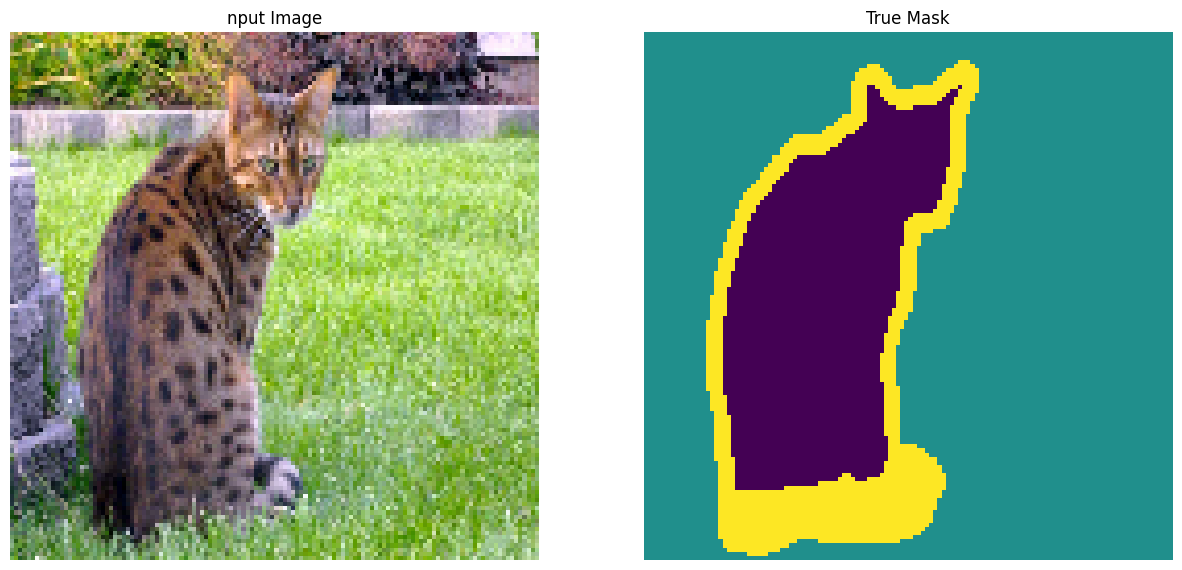

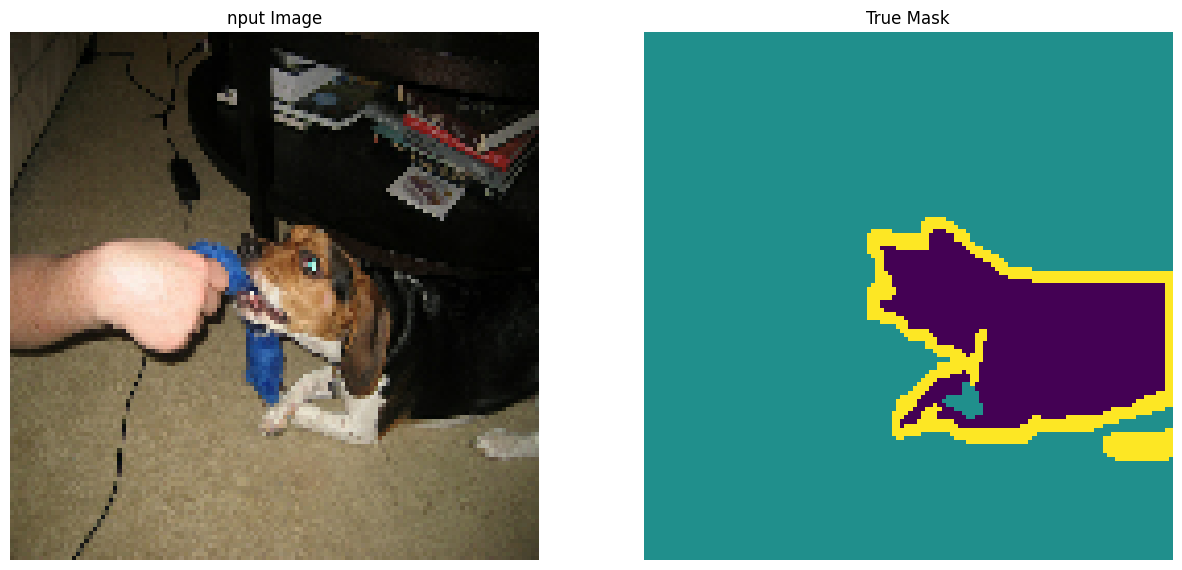

In [ ]:
for images, masks in train_batches.take(2):
  sample_image, sample_mask = images[0], masks[0]
  display([sample_image, sample_mask])

In [ ]:
base_model = tf.keras.applications.MobileNetV2( input_shape=[128, 128, 3],
  include_top=False)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:
layer_names = [
'block_1_expand_relu', # 64x64 размерность
'block_3_expand_relu', # 32x32 размерность
'block_6_expand_relu', # 16x16 размерность
'block_13_expand_relu', # 8x8 размерность
'block_16_project', # 4x4 размерность
]

In [ ]:
base_model_outputs =\
[base_model.get_layer(name).output for name in layer_names]
# Создаем энкодерную часть модели (downsampler):
down_stack = tf.keras.Model(inputs=base_model.input,
outputs=base_model_outputs)
down_stack.trainable = False
# замораживаем коэффициенты предобученной модели MobileNet2

In [ ]:
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)
# инициализатор с нормальным распределением (m=0, sigma=0.02)
  result = tf.keras.Sequential()
  result.add(
  tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
  padding='same',
  kernel_initializer=initializer,
  use_bias=False))
  result.add(tf.keras.layers.BatchNormalization())
  if apply_dropout:
    result.add(tf.keras.layers.Dropout(0.5))
    result.add(tf.keras.layers.ReLU())
  return result

In [ ]:
up_stack = [
upsample(512, 3), # 4x4 -> 8x8 после Conv2DTranspose
upsample(256, 3), # 8x8 -> 16x16 ...
upsample(128, 3), # 16x16 -> 32x32 ...
upsample(64, 3), # 32x32 -> 64x64 ...
]

In [ ]:
def unet_model(output_channels:int):
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])
  skips = down_stack(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])
# Итоговый слой должен выдать маску 128x128
  last = tf.keras.layers.Conv2DTranspose(
  filters=output_channels, kernel_size=3, strides=2,
  padding='same') #64x64 -> 128x128
  x = last(x)
  return tf.keras.Model(inputs=inputs, outputs=x)

In [ ]:
OUTPUT_CLASSES = 3
model = unet_model(output_channels=OUTPUT_CLASSES)
model.compile(optimizer='adam',
loss=tf.keras.losses.SparseCategoricalCrossentropy(
from_logits=True),
# Выходы не нормализованы, поэтому мы используем logits
metrics=['accuracy'])

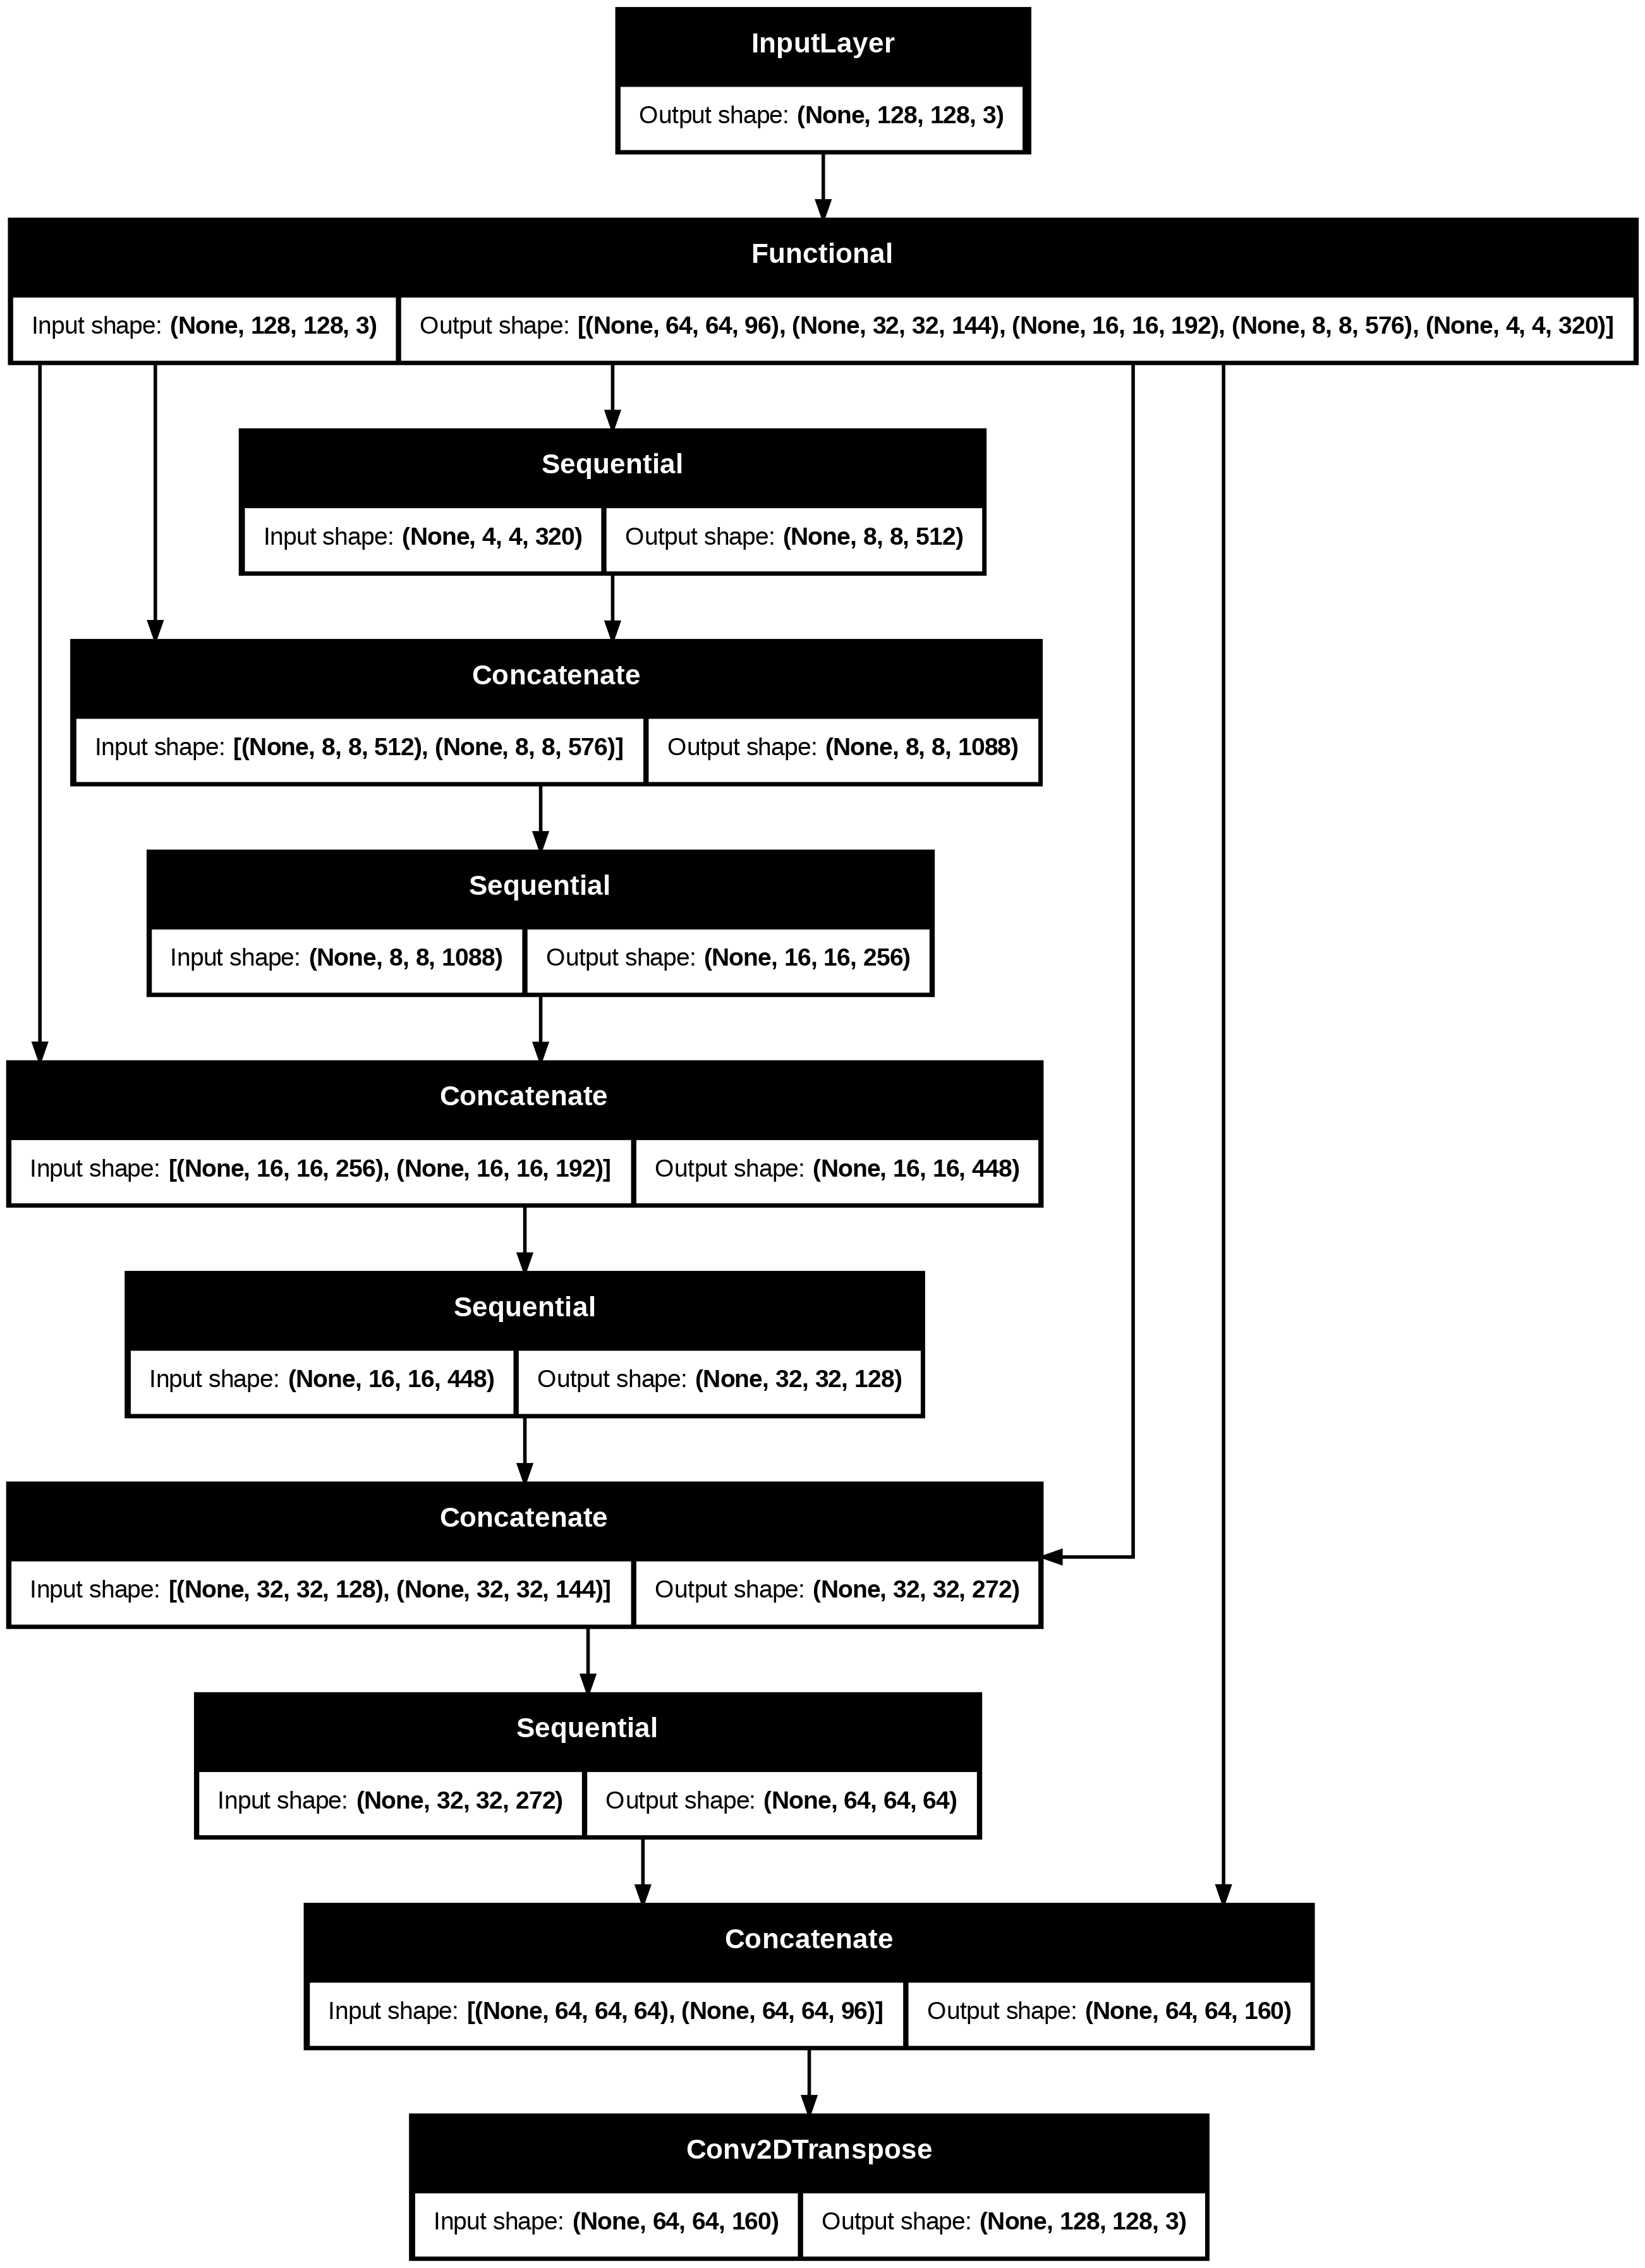

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
def create_mask(pred_mask):
  pred_mask = tf.math.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

def show_predictions(dataset, num=1):
  for image, mask in dataset.take(num):
    pred_mask = model.predict(image)
    display([image[0], mask[0], create_mask(pred_mask)])

In [ ]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions(train_batches)
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


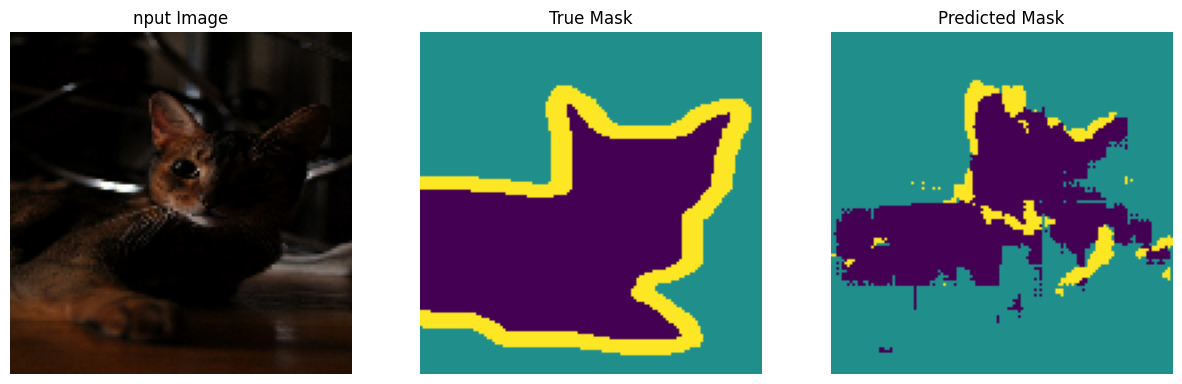


Sample Prediction after epoch 20

57/57 ━━━━━━━━━━━━━━━━━━━━ 9s 162ms/step - accuracy: 0.8932 - loss: 0.2763 - val_accuracy: 0.8909 - val_loss: 0.2919


In [ ]:
EPOCHS = 20
VAL_SUBSPLITS = 5 # разобъем процесс валидации на 5 этапов
VALIDATION_STEPS =\
info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS
model_history = model.fit(train_batches, epochs=EPOCHS,
steps_per_epoch=STEPS_PER_EPOCH,
validation_steps=VALIDATION_STEPS,
validation_data=test_batches,
callbacks=[DisplayCallback()])

In [ ]:
base_model_outputs =\
[base_model.get_layer(name).output for name in layer_names]
# Создаем энкодерную часть модели (downsampler):
down_stack = tf.keras.Model(inputs=base_model.input,
outputs=base_model_outputs)
down_stack.trainable = True
# размораживаем коэффициенты предобученной модели MobileNet2

In [ ]:
up_stack = [
upsample(512, 3, True), # 4x4 -> 8x8 после Conv2DTranspose
upsample(256, 3, True), # 8x8 -> 16x16 ...
upsample(128, 3, True), # 16x16 -> 32x32 ...
upsample(64, 3, True), # 32x32 -> 64x64 ...
]

In [ ]:
OUTPUT_CLASSES = 3
model_2 = unet_model(output_channels=OUTPUT_CLASSES)
model_2.compile(optimizer='adam',
loss=tf.keras.losses.SparseCategoricalCrossentropy(
from_logits=True),
metrics=['accuracy'])

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step 


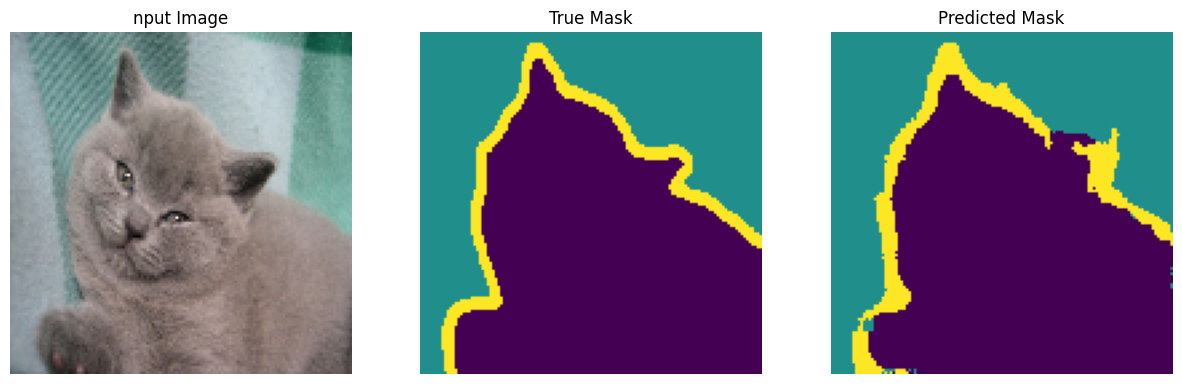


Sample Prediction after epoch 20

57/57 ━━━━━━━━━━━━━━━━━━━━ 10s 168ms/step - accuracy: 0.9061 - loss: 0.2401 - val_accuracy: 0.9039 - val_loss: 0.2608


In [ ]:
EPOCHS = 20
VAL_SUBSPLITS = 5 # разобъем процесс валидации на 5 этапов
VALIDATION_STEPS =\
info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS
model_history_2 = model_2.fit(train_batches, epochs=EPOCHS,
steps_per_epoch=STEPS_PER_EPOCH,
validation_steps=VALIDATION_STEPS,
validation_data=test_batches,
callbacks=[DisplayCallback()])

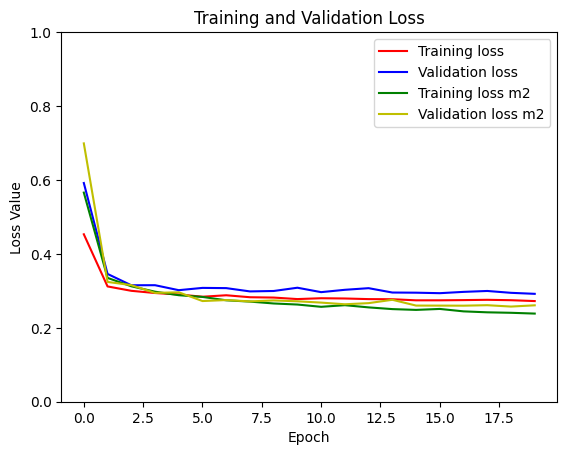

In [ ]:
loss = model_history.history['loss']
loss_2 = model_history_2.history['loss']
val_loss = model_history.history['val_loss']
val_loss_2 = model_history_2.history['val_loss']
plt.plot(model_history.epoch, loss, 'r', label='Training loss')
plt.plot(model_history.epoch, val_loss, 'b', label='Validation loss')
plt.plot(model_history_2.epoch, loss_2, 'g', label='Training loss m2')
plt.plot(model_history_2.epoch, val_loss_2, 'y', label='Validation loss m2')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

In [ ]:
import zipfile

# Путь к архиву на Google Drive
zip_path = '/content/drive/MyDrive/archive.zip'

# Распаковка
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/dataset')

In [ ]:
import os
import cv2
import kagglehub
import numpy as np

def load_data(image_dir, mask_dir):
    images = []
    masks = []
    for img_name in os.listdir(image_dir):
        img_path = os.path.join(image_dir, img_name)
        mask_path = os.path.join(mask_dir, img_name)

        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        img = cv2.resize(img, (128, 128))
        mask = cv2.resize(mask, (128, 128))

        images.append(img)
        masks.append(mask)

    return np.array(images), np.array(masks)


image_dir = '/content/dataset/Water_Bodies_Dataset_Split/train_images'
mask_dir = '/content/dataset/Water_Bodies_Dataset_Split/train_masks'

images, masks = load_data(image_dir, mask_dir)

images = images / 255.0
masks = masks / 255.0

In [ ]:
image_dir = '/content/dataset/Water_Bodies_Dataset_Split/valid_images'
mask_dir = '/content/dataset/Water_Bodies_Dataset_Split/valid_masks'

valid_images, valid_masks = load_data(image_dir, mask_dir)
valid_images = valid_images / 255.0
valid_masks = valid_masks / 255.0

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate

def unet(input_size=(128, 128, 3)):
    inputs = Input(input_size)

    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)

    up5 = concatenate([UpSampling2D(size=(2, 2))(conv4), conv3], axis=-1)
    conv5 = Conv2D(256, 3, activation='relu', padding='same')(up5)
    conv5 = Conv2D(256, 3, activation='relu', padding='same')(conv5)

    up6 = concatenate([UpSampling2D(size=(2, 2))(conv5), conv2], axis=-1)
    conv6 = Conv2D(128, 3, activation='relu', padding='same')(up6)
    conv6 = Conv2D(128, 3, activation='relu', padding='same')(conv6)

    up7 = concatenate([UpSampling2D(size=(2, 2))(conv6), conv1], axis=-1)
    conv7 = Conv2D(64, 3, activation='relu', padding='same')(up7)
    conv7 = Conv2D(64, 3, activation='relu', padding='same')(conv7)

    outputs = Conv2D(1, 1, activation='sigmoid')(conv7)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

model = unet()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6             │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 128, 128, 64)   │          1,792 │ input_layer_6[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 128, 128, 64)   │         36,928 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 64, 64, 64)     │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 64, 64, 128)    │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 64, 64, 128)    │        147,584 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 32, 32, 128)    │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 32, 32, 256)    │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 32, 32, 256)    │        590,080 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 16, 16, 256)    │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 16, 16, 512)    │      1,180,160 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 16, 16, 512)    │      2,359,808 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d             │ (None, 32, 32, 512)    │              0 │ conv2d_7[0][0]         │
│ (UpSampling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_4             │ (None, 32, 32, 768)    │              0 │ up_sampling2d[0][0],   │
│ (Concatenate)             │                        │                │ conv2d_5[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 32, 32, 256)    │      1,769,728 │ concatenate_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 32, 32, 256)    │        590,080 │ conv2d_8[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d_1      

 Total params: 7,782,913 (29.69 MB)

 Trainable params: 7,782,913 (29.69 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(images, masks, validation_data=(valid_images, valid_masks), epochs=20, batch_size=16)

model.save('unet_water_segmentation.h5')

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_183']
Received: inputs=Tensor(shape=(None, 128, 128, 3))
  warnings.warn(msg)


168/168 ━━━━━━━━━━━━━━━━━━━━ 87s 361ms/step - accuracy: 0.6127 - loss: 0.6266 - val_accuracy: 0.6221 - val_loss: 0.5318
Epoch 2/20
168/168 ━━━━━━━━━━━━━━━━━━━━ 28s 164ms/step - accuracy: 0.6395 - loss: 0.4958 - val_accuracy: 0.6792 - val_loss: 0.4389
Epoch 3/20
168/168 ━━━━━━━━━━━━━━━━━━━━ 41s 163ms/step - accuracy: 0.6646 - loss: 0.4625 - val_accuracy: 0.7146 - val_loss: 0.3740
Epoch 4/20
168/168 ━━━━━━━━━━━━━━━━━━━━ 41s 165ms/step - accuracy: 0.6921 - loss: 0.4090 - val_accuracy: 0.7354 - val_loss: 0.3500
Epoch 5/20
168/168 ━━━━━━━━━━━━━━━━━━━━ 41s 164ms/step - accuracy: 0.7087 - loss: 0.3769 - val_accuracy: 0.7463 - val_loss: 0.3240
Epoch 6/20
168/168 ━━━━━━━━━━━━━━━━━━━━ 41s 164ms/step - accuracy: 0.7213 - loss: 0.3542 - val_accuracy: 0.7455 - val_loss: 0.3310
Epoch 7/20
168/168 ━━━━━━━━━━━━━━━━━━━━ 27s 163ms/step - accuracy: 0.7186 - loss: 0.3517 - val_accuracy: 0.7449 - val_loss: 0.3229
Epoch 8/20
168/168 ━━━━━━━━━━━━━━━━━━━━ 27s 163ms/step - accuracy: 0.7325 - loss: 0.3311 - val

In [ ]:
loss, accuracy = model.evaluate(valid_images, valid_masks)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')

5/5 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.7656 - loss: 0.2605
Test Loss: 0.2584475874900818
Test Accuracy: 0.7747687101364136


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_183']
Received: inputs=Tensor(shape=(32, 128, 128, 3))
  warnings.warn(msg)


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 364ms/step


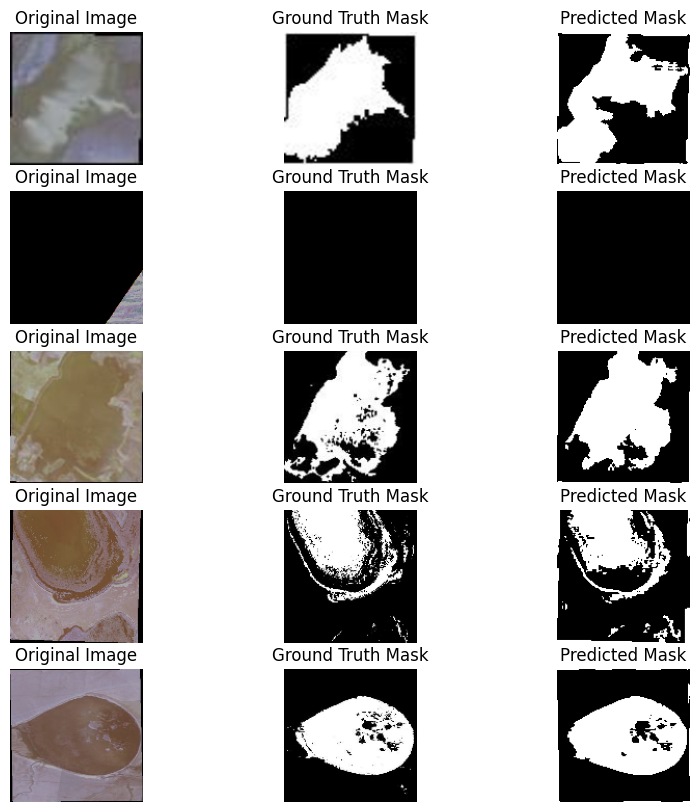

In [ ]:
import matplotlib.pyplot as plt

preds = model.predict(valid_images)
preds = (preds > 0.5).astype(np.uint8)

plt.figure(figsize=(10, 10))
for i in range(5):
    plt.subplot(5, 3, i*3 + 1)
    plt.imshow(valid_images[i])
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(5, 3, i*3 + 2)
    plt.imshow(valid_masks[i], cmap='gray')
    plt.title('Ground Truth Mask')
    plt.axis('off')

    plt.subplot(5, 3, i*3 + 3)
    plt.imshow(preds[i], cmap='gray')
    plt.title('Predicted Mask')
    plt.axis('off')
plt.show()